## Contexte du Projet

La ville de Seattle s'est fixée un objectif ambitieux : **atteindre la neutralité carbone d'ici 2050**. 

Pour y parvenir, l'équipe municipale doit comprendre et optimiser la consommation énergétique des bâtiments non résidentiels (bureaux, hôpitaux, commerces, etc.).

### Problématique

Notre mission : **prédire la consommation d'énergie** des bâtiments pour lesquels les mesures n'ont pas encore été effectuées, en utilisant uniquement leurs caractéristiques structurelles.

### Données disponibles

- **Source** : Seattle Building Energy Benchmarking 2016
- **Année** : 2016
- **Type** : Bâtiments non résidentiels de Seattle
- **Variables** : Caractéristiques structurelles (taille, âge, usage) + Consommations énergétiques

### Objectifs de ce notebook

1. **Analyse Exploratoire** : Comprendre la structure des données, traiter les valeurs manquantes et identifier les variables discriminantes.

2. **Energie & Corrélations** : Analyser la distribution de la variable cible et étudier les relations entre les caractéristiques physiques (surface, âge, usage) et la consommation

3. **Nettoyage & Feature Engineering** : Filtrage des outliers et Creation des variables pertinentes pour la modélisation , Transformation logarithmique des variables asymétriques pour stabiliser la variance, et Encodage des variables catégorielles

4. **Préparation des données pour la modélisation** : Standardisation des données et comparaison de modèles de référence (Régression Linéaire, SVR, Random Forest) via validation croisée.

5. **Optimisation du modele selectionné** : Recherche des meilleurs hyperparamètres pour le modèle SVR via GridSearchCV.

6. **Evaluation Finale et Analyse des résidus** : Vérification des performances sur le jeu de test et analyse de la distribution des erreurs pour valider la robustesse du modèle.

7. **Etude de l'Energy Star Score** : Évaluer l'apport de cette variable sur la précision du modèle et discuter de son coût d'obtention par rapport au gain de performance.

8. **Conclusion générale** : Synthèse des résultats et recommandations métier pour la ville de Seattle.

# 1. Analyse Exploratoire des Données (EDA)

Cette partie vise à comprendre la structure du jeu de données, la qualité
des informations disponibles et les relations initiales entre les variables.

L’analyse exploratoire est une étape clé pour :
- détecter les problèmes de qualité de données
- comprendre les distributions
- orienter le feature engineering
- éviter les erreurs de modélisation (notamment le data leakage)


## Import des librairies et configuration graphique

In [1]:
# Manipulation des données
import pandas as pd
import numpy as np
import joblib
import warnings

# Visualisation
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Configuration esthétique
warnings.filterwarnings("ignore")
sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)
plt.rcParams["axes.titlesize"] = 15
plt.rcParams["axes.titleweight"] = 'bold'
colors = ["#2ecc71", "#3498db", "#95a5a6", "#e74c3c", "#34495e"]
sns.set_palette(colors)

# Prétraitement & Validation 
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

# Modèles 
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor

# Métriques & Interprétation 
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.inspection import permutation_importance

# Mission 2 (API)
import bentoml

## Chargement des données

In [2]:
# Chargement et accés aux données
data_path = "../data/2016_Building_Energy_Benchmarking.csv"
df = pd.read_csv(data_path)

print(f"Dimensions initiales du dataset : {df.shape}")

# On regarde comment un batiment est défini dans ce jeu de données 
df.head()

Dimensions initiales du dataset : (3376, 46)


,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,...,Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
0,1,2016,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,98101.0,0659000030,...,1.156514e+06,3946027.0,12764.52930,1276453.0,False,NaN,Compliant,NaN,249.98,2.83
1,2,2016,NonResidential,Hotel,Paramount Hotel,724 Pine street,Seattle,WA,98101.0,0659000220,...,9.504252e+05,3242851.0,51450.81641,5145082.0,False,NaN,Compliant,NaN,295.86,2.86
2,3,2016,NonResidential,Hotel,5673-The Westin Seattle,1900 5th Avenue,Seattle,WA,98101.0,0659000475,...,1.451544e+07,49526664.0,14938.00000,1493800.0,False,NaN,Compliant,NaN,2089.28,2.19
3,5,2016,NonResidential,Hotel,HOTEL MAX,620 STEWART ST,Seattle,WA,98101.0,0659000640,...,8.115253e+05,2768924.0,18112.13086,1811213.0,False,NaN,Compliant,NaN,286.43,4.67
4,8,2016,NonResidential,Hotel,WARWICK SEATTLE HOTEL (ID8),401 LENORA ST,Seattle,WA,98121.0,0659000970,...,1.573449e+06,5368607.0,88039.98438,8803998.0,False,NaN,Compliant,NaN,505.01,2.88


Chaque ligne du jeu de données correspond à un bâtiment non résidentiel
ou résidentiel de la ville de Seattle pour l’année 2016.


## Structure du jeu de données

In [3]:
# On regarde le nombre de valeurs manquantes par colonne ainsi que leur type 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3376 entries, 0 to 3375
Data columns (total 46 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   OSEBuildingID                    3376 non-null   int64  
 1   DataYear                         3376 non-null   int64  
 2   BuildingType                     3376 non-null   object 
 3   PrimaryPropertyType              3376 non-null   object 
 4   PropertyName                     3376 non-null   object 
 5   Address                          3376 non-null   object 
 6   City                             3376 non-null   object 
 7   State                            3376 non-null   object 
 8   ZipCode                          3360 non-null   float64
 9   TaxParcelIdentificationNumber    3376 non-null   object 
 10  CouncilDistrictCode              3376 non-null   int64  
 11  Neighborhood                     3376 non-null   object 
 12  Latitude            

Cette première inspection permet d’identifier :
- le nombre de variables numériques et catégorielles
- la présence de valeurs manquantes
- les types de données (int, float, object)

In [4]:
# Nombre de bâtiments avant filtrage
df.shape

(3376, 46)

In [5]:
# Exploration des types de bâtiments
df["BuildingType"].value_counts()

BuildingType
NonResidential          1460
Multifamily LR (1-4)    1018
Multifamily MR (5-9)     580
Multifamily HR (10+)     110
SPS-District K-12         98
Nonresidential COS        85
Campus                    24
Nonresidential WA          1
Name: count, dtype: int64

## Filtrage des données
La mission se concentre exclusivement sur les bâtiments non résidentiels. Nous effectuons ce filtrage immédiatement pour ne pas polluer l'analyse.

In [6]:
# Filtrage Non-Résidentiel
initial_count = len(df)
df = df[df["BuildingType"].str.contains("NonResidential", na=False)]
final_count = len(df)

print(f" FILTRAGE MÉTIER ")
print(f"Dimensions initiales : {initial_count}")
print(f"Bâtiments conservés (Non-Résidentiels) : {final_count}")
print(f"Supprimés : {initial_count - final_count}")

 FILTRAGE MÉTIER 
Dimensions initiales : 3376
Bâtiments conservés (Non-Résidentiels) : 1460
Supprimés : 1916


## Analyse de la Qualité (Valeurs Manquantes)

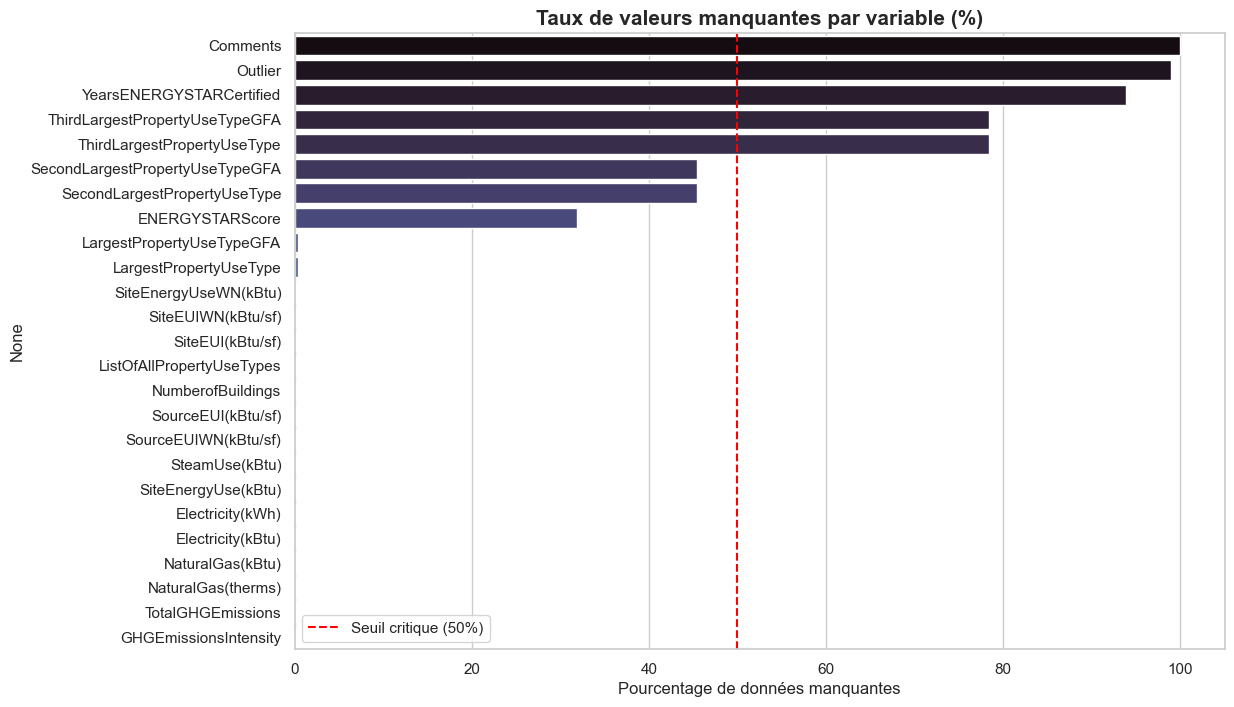

In [7]:
missing = df.isna().mean() * 100
missing = missing[missing > 0].sort_values(ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x=missing.values, y=missing.index, palette="mako")
plt.title("Taux de valeurs manquantes par variable (%)")
plt.xlabel("Pourcentage de données manquantes")
plt.axvline(x=50, color='red', linestyle='--', label='Seuil critique (50%)')
plt.legend()
plt.show()

### Statistique des variables numériques

In [8]:
# Aperçu statistique des variables numériques
df.describe().T

,count,mean,std,min,25%,50%,75%,max
OSEBuildingID,1460.0,1.610535e+04,1.333520e+04,1.00000,6.097500e+02,2.114050e+04,2.456700e+04,5.009400e+04
DataYear,1460.0,2.016000e+03,0.000000e+00,2016.00000,2.016000e+03,2.016000e+03,2.016000e+03,2.016000e+03
ZipCode,1460.0,9.811660e+04,1.867266e+01,98006.00000,9.810400e+04,9.810900e+04,9.812500e+04,9.819900e+04
CouncilDistrictCode,1460.0,4.423288e+00,2.190766e+00,1.00000,2.000000e+00,4.000000e+00,7.000000e+00,7.000000e+00
Latitude,1460.0,4.761611e+01,4.661638e-02,47.50959,4.758786e+01,4.761242e+01,4.764887e+01,4.773387e+01
Longitude,1460.0,-1.223335e+02,2.301060e-02,-122.41182,-1.223423e+02,-1.223332e+02,-1.223228e+02,-1.222618e+02
YearBuilt,1460.0,1.960844e+03,3.296633e+01,1900.00000,1.929000e+03,1.965000e+03,1.988000e+03,2.015000e+03
NumberofBuildings,1458.0,1.034294e+00,5.409043e-01,0.00000,1.000000e+00,1.000000e+00,1.000000e+00,9.000000e+00
NumberofFloors,1460.0,4.370548e+00,6.763737e+00,0.00000,1.000000e+00,3.000000e+00,5.000000e+00,9.900000e+01
PropertyGFATotal,1460.0,1.130373e+05,1.923444e+05,16300.00000,2.916050e+04,4.800350e+04,1.041622e+05,1.952220e+06


## Analyse de la Variable cible : consommation énergétique (SiteEnergyUse(kBtu))

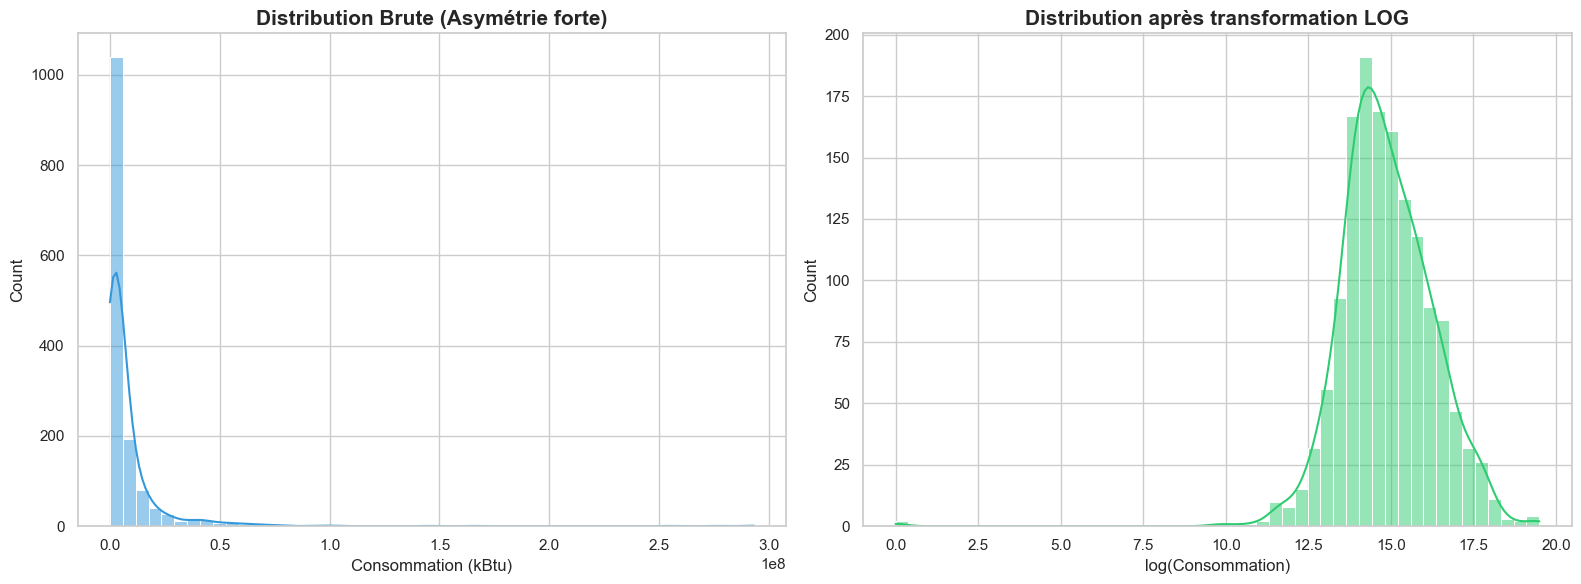

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Distribution Brute
sns.histplot(df["SiteEnergyUse(kBtu)"], bins=50, ax=axes[0], color="#3498db", kde=True)
axes[0].set_title("Distribution Brute (Asymétrie forte)")
axes[0].set_xlabel("Consommation (kBtu)")

# Distribution Log
df["SiteEnergyUse_log"] = np.log1p(df["SiteEnergyUse(kBtu)"])
sns.histplot(df["SiteEnergyUse_log"], bins=50, ax=axes[1], color="#2ecc71", kde=True)
axes[1].set_title("Distribution après transformation LOG")
axes[1].set_xlabel("log(Consommation)")

plt.tight_layout()
plt.show()

La distribution est fortement asymétrique à droite,
ce qui peut poser problème pour certains modèles.

La transformation logarithmique permet de :
- réduire l’influence des valeurs extrêmes
- stabiliser la variance
- améliorer les performances des modèles


## Analyse des Surfaces et Nettoyage des Outliers
Les très gros bâtiments (stades, centres commerciaux géants) peuvent fausser la prédiction pour le parc immobilier standard. Nous filtrons les valeurs extrêmes.

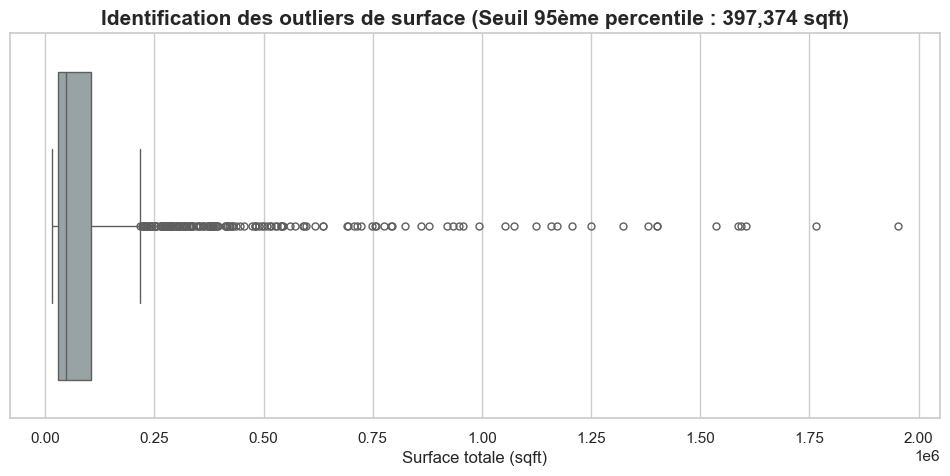

In [10]:
# Avant/Après filtrage des outliers sur la surface
q_high = df["PropertyGFATotal"].quantile(0.95)
df_filtered = df[df["PropertyGFATotal"] < q_high]

plt.figure(figsize=(12, 5))
sns.boxplot(x=df["PropertyGFATotal"], color="#95a5a6", fliersize=5)
plt.title(f"Identification des outliers de surface (Seuil 95ème percentile : {q_high:,.0f} sqft)")
plt.xlabel("Surface totale (sqft)")
plt.show()

# On applique le filtrage
df = df_filtered

Le filtrage des valeurs extrêmes permet d’éviter que quelques très grands bâtiments
n’écrasent l’apprentissage des modèles.

## Analyse de l'Âge et du Mix Énergétique

L’âge des bâtiments est une variable explicative clé,
car il reflète les normes énergétiques en vigueur lors de la construction.


Features energetiques creees
   Electricite : 1381 batiments (99.6%)
   Gaz naturel : 970 batiments (69.9%)


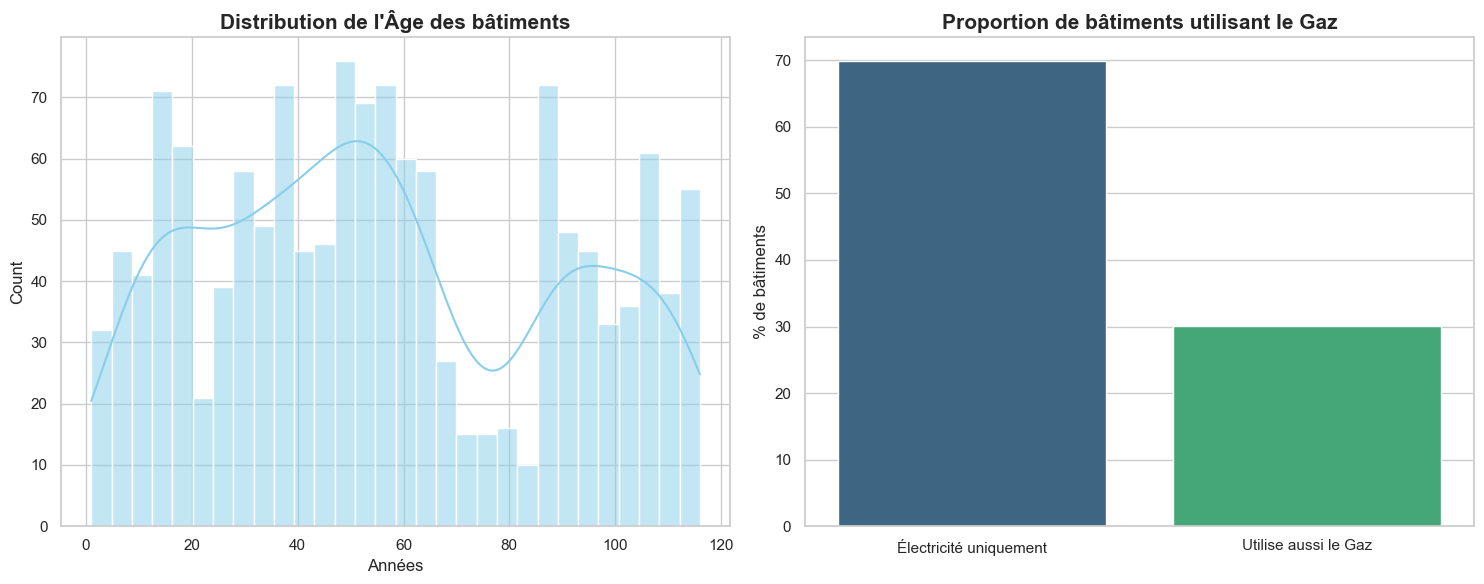

In [11]:
# 1. Calculs (Age et indicateurs)
df["BuildingAge"] = 2016 - df["YearBuilt"]
df["HasElectricity"] = (df["Electricity(kWh)"] > 0).astype(int)
df["HasGas"] = (df["NaturalGas(kBtu)"] > 0).astype(int)

# Vérification
print(f"Features energetiques creees")
print(f"   Electricite : {df['HasElectricity'].sum()} batiments ({100*df['HasElectricity'].mean():.1f}%)")
print(f"   Gaz naturel : {df['HasGas'].sum()} batiments ({100*df['HasGas'].mean():.1f}%)")


# On crée une figure avec 1 ligne et 2 colonnes. 
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# 2. Graphique de Gauche (Age du bâtiment)
sns.histplot(df["BuildingAge"], bins=30, kde=True, ax=axes[0], color="skyblue")
axes[0].set_title("Distribution de l'Âge des bâtiments")
axes[0].set_xlabel("Années")

# 3. Graphique de Droite Proportion de batiments utilisant le GAZ
gas_counts = df["HasGas"].value_counts(normalize=True) * 100
sns.barplot(x=["Électricité uniquement", "Utilise aussi le Gaz"], 
            y=gas_counts.values, 
            ax=axes[1], 
            palette="viridis")

axes[1].set_title("Proportion de bâtiments utilisant le Gaz")
axes[1].set_ylabel("% de bâtiments")

# Ajustement et affichage
plt.tight_layout()
plt.show()

Cette analyse permet d’identifier :
- les bâtiments tout électrique
- ceux utilisant le gaz
- ceux utilisant une combinaison des deux

## Relation Fondamentale : Surface vs Consommation

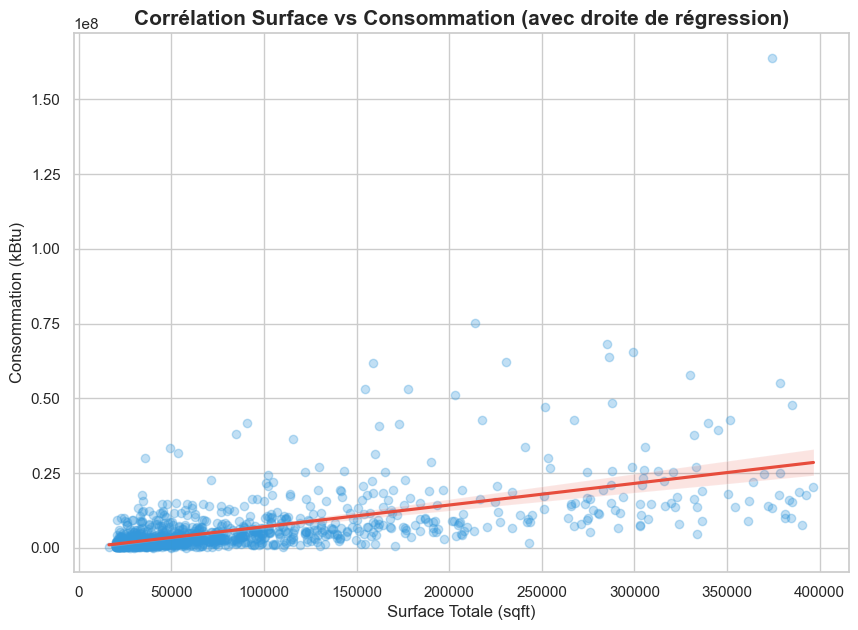

In [12]:
plt.figure(figsize=(10, 7))
sns.regplot(data=df, x="PropertyGFATotal", y="SiteEnergyUse(kBtu)", 
            scatter_kws={'alpha':0.3, 'color':'#3498db'}, 
            line_kws={'color':'#e74c3c'})
plt.title("Corrélation Surface vs Consommation (avec droite de régression)")
plt.xlabel("Surface Totale (sqft)")
plt.ylabel("Consommation (kBtu)")
plt.show()

On observe une relation positive claire :
plus un bâtiment est grand, plus sa consommation est élevée.

## Synthèse Partie 1 : de l'Analyse Exploratoire
Transformation Log : La cible SiteEnergyUse a été normalisée pour stabiliser la variance.

Filtrage Outliers : Nous avons écarté les 5% de bâtiments les plus vastes pour garantir la généralisation du modèle sur le parc standard.

Variables discriminantes : La Surface et le Mix énergétique (HasGas) apparaissent comme les variables ayant le plus fort impact visuel sur la cible.

Qualité : Les variables avec plus de 50% de valeurs manquantes seront exclues lors de la phase de Feature Engineering.

# 2. ÉNERGIE & CORRÉLATIONS

Cette section approfondit la compréhension des leviers de consommation. Nous allons analyser comment le mix énergétique, l'usage du bâtiment et les caractéristiques structurelles (surface, âge) interagissent avec notre cible.

In [13]:
# Configuration des couleurs pour cette partie
energy_palette = ["#3498db", "#e67e22", "#2ecc71", "#95a5a6"]
usage_palette = "viridis"

## Typologie énergétique des bâtiments

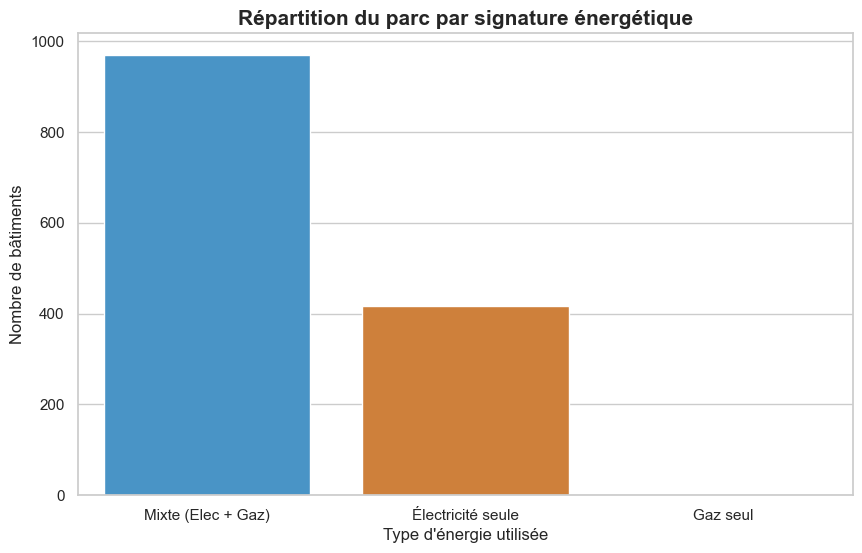

In [14]:
# Création d'une variable catégorielle d'énergie
def energy_type(row):
    if row.get("HasElectricity") == 1 and row.get("HasGas") == 1:
        return "Mixte (Elec + Gaz)"
    elif row.get("HasGas") == 1:
        return "Gaz seul"
    else:
        return "Électricité seule"

df["EnergyType"] = df.apply(energy_type, axis=1)

# Visualisation avec des couleurs distinctes
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x="EnergyType", palette=energy_palette, order=df["EnergyType"].value_counts().index)
plt.title("Répartition du parc par signature énergétique")
plt.xlabel("Type d'énergie utilisée")
plt.ylabel("Nombre de bâtiments")
plt.show()

La majorité des bâtiments utilise une combinaison
électricité + gaz, ce qui justifie l’intégration
d’une variable binaire indiquant la présence du gaz.

## Impact du mix énergétique sur la consommation

Nous utilisons un Boxplot pour comparer les distributions. Utiliser l'échelle logarithmique permet de mieux visualiser les différences de moyennes.

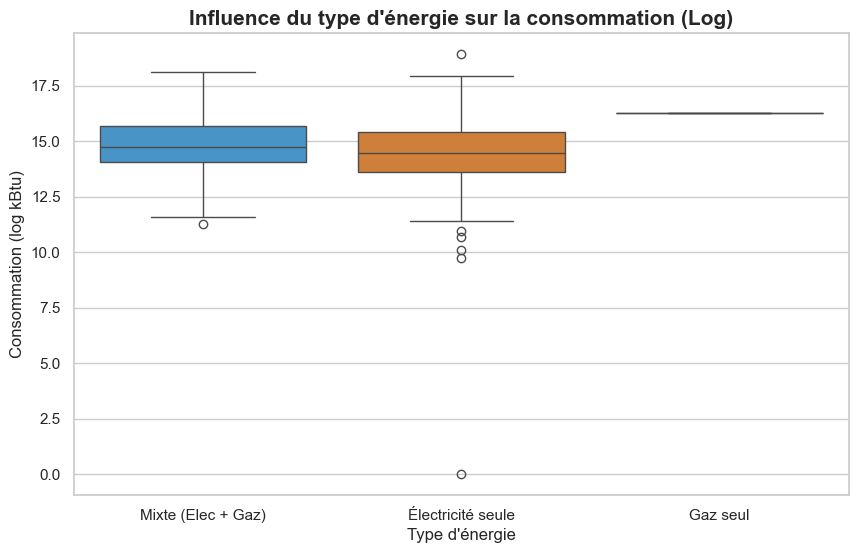

In [15]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x="EnergyType", y="SiteEnergyUse_log", palette=energy_palette)
plt.title("Influence du type d'énergie sur la consommation (Log)")
plt.xlabel("Type d'énergie")
plt.ylabel("Consommation (log kBtu)")
plt.show()

## Analyse par usage : Quels sont les bâtiments les plus gourmands ?

In [16]:
# Calcul de la mediane de consommation par type d'usage
df_top = df.groupby("PrimaryPropertyType")["SiteEnergyUse_log"].median().reset_index()

# Tri des donnees pour affichage du plus gourmand au moins gourmand
order = df_top.sort_values("SiteEnergyUse_log", ascending=False)["PrimaryPropertyType"]

# Selection du top 15 pour lisibilite
top_15_types = order[:15]
df_top_filtered = df[df["PrimaryPropertyType"].isin(top_15_types)]

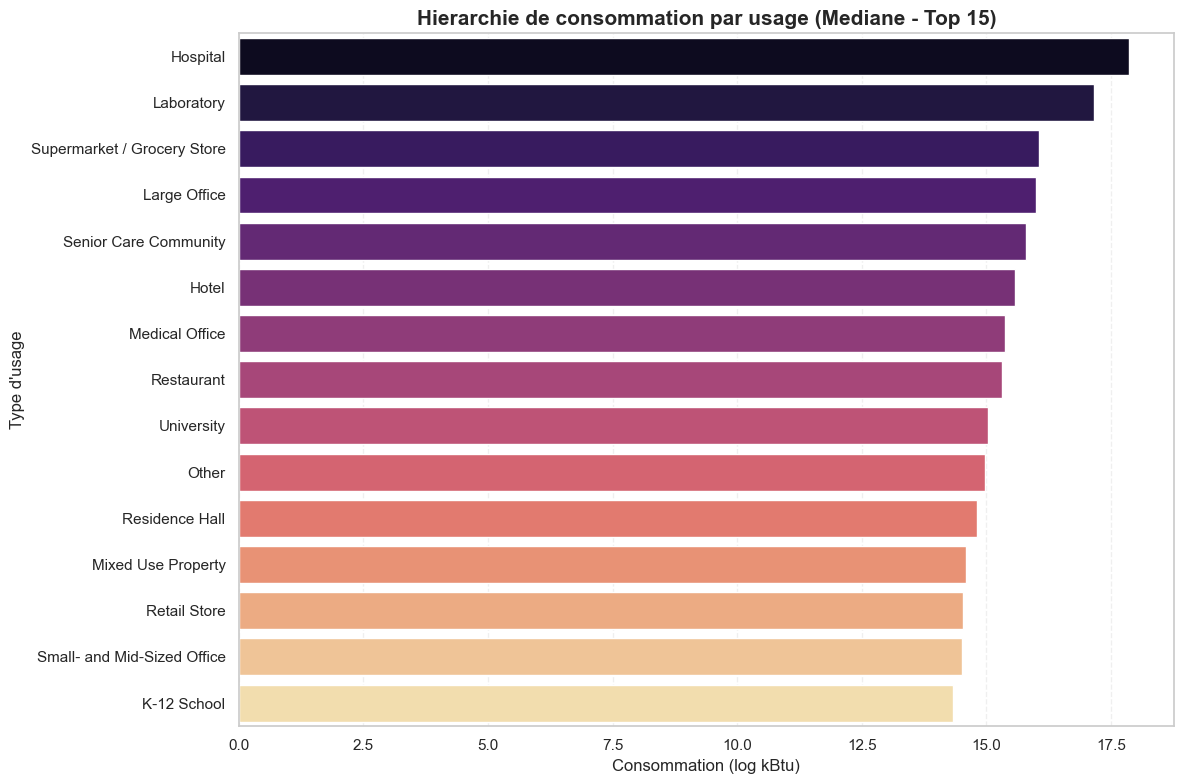

21 types de batiments analyses


In [17]:
plt.figure(figsize=(12, 8))
sns.barplot(
    data=df_top_filtered, 
    y="PrimaryPropertyType",
    x="SiteEnergyUse_log", 
    order=top_15_types, 
    palette="magma",
    estimator=np.median,
    errorbar=None
)

plt.title("Hierarchie de consommation par usage (Mediane - Top 15)", fontsize=15)
plt.xlabel("Consommation (log kBtu)")
plt.ylabel("Type d'usage")
plt.grid(axis='x', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

print(f"{len(df['PrimaryPropertyType'].unique())} types de batiments analyses")

## Relation Surface vs Consommation

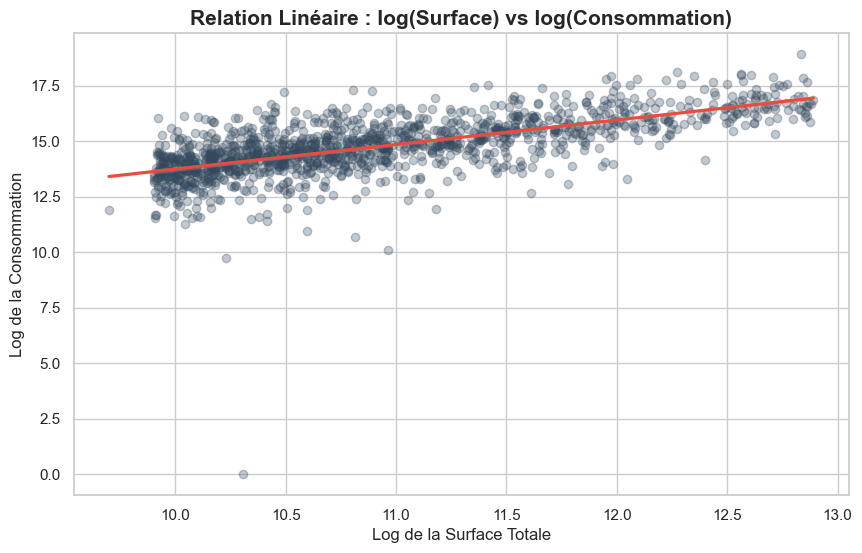

In [18]:
plt.figure(figsize=(10, 6))
# On utilise log(surface) pour une relation linéaire parfaite
sns.regplot(
    x=np.log1p(df["PropertyGFATotal"]), 
    y=df["SiteEnergyUse_log"],
    scatter_kws={'alpha':0.3, 'color':'#34495e'},
    line_kws={'color':'#e74c3c'}
)
plt.title("Relation Linéaire : log(Surface) vs log(Consommation)")
plt.xlabel("Log de la Surface Totale")
plt.ylabel("Log de la Consommation")
plt.show()

La relation devient quasi linéaire après transformation logarithmique,
ce qui est favorable à de nombreux modèles de régression.

## Matrice de Corrélation

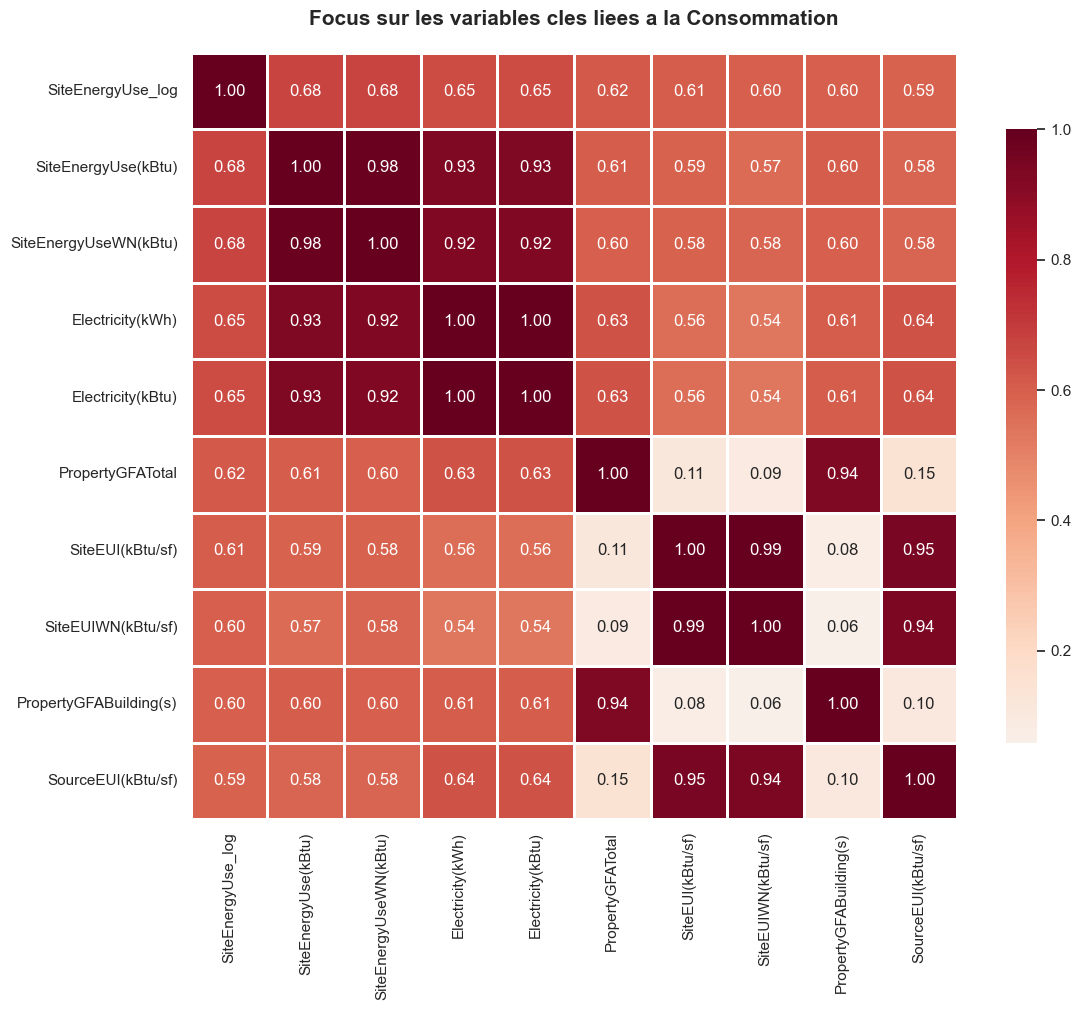

In [19]:
# Selection des variables numeriques pour l'analyse de correlation
df_numeric = df.select_dtypes(include=[np.number])

# Calcul de la correlation avec la cible
target_corr = df_numeric.corr()['SiteEnergyUse_log'].sort_values(ascending=False)

# Selection des 12 variables les plus correlees (positives et negatives)
top_features = target_corr.head(10).index.tolist()

# Creation de la matrice de correlation focalisee
corr = df_numeric[top_features].corr()

# Visualisation
plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(corr, dtype=bool))

sns.heatmap(
    corr,
    #mask=mask,
    annot=True,
    fmt=".2f",
    cmap="RdBu_r",
    center=0,
    square=True,
    linewidths=1,
    cbar_kws={"shrink": .8}
)

plt.title("Focus sur les variables cles liees a la Consommation", fontsize=15, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()


Analyse de la corrélation : 
- La matrice confirme que la surface totale (PropertyGFATotal) est le principal moteur physique de la consommation avec une corrélation de 0.62.
- la forte corrélation entre la cible en log et les variables réelles (0.68) valide la cohérence de la transformation logarithmique utilisée pour la modélisation.

### Synthèse Partie 2 : Energie & Corrélations

✔ La surface est le principal facteur explicatif  
✔ Le type d’énergie apporte une information pertinente  
✔ L’âge et le nombre d’étages jouent un rôle secondaire  
✔ Le type d’usage du bâtiment est crucial  

Ces éléments guident directement :
- la sélection des features
- la création de variables
- le choix des modèles

## 3. Feature Engineering

Le feature engineering consiste à transformer les données brutes
en variables exploitables par les modèles de machine learning.

Objectifs :
- améliorer la capacité prédictive du modèle
- intégrer du sens métier
- limiter la complexité
- éviter toute fuite d’information (data leakage)

## Demarche anti-Leakage (Sécurité des données)
Pour garantir un modèle prédictif réel, nous devons supprimer toutes les variables qui "connaissent" déjà la réponse (consommations détaillées) ou qui sont calculées à partir d'elle (émissions, intensités).

Ces variables ne doivent **jamais** être utilisées comme features.

In [20]:
# Liste exhaustive pour supprimer TOUTE fuite de données
leakage_cols = [
    # La cible et ses variantes météo
    "SiteEnergyUse(kBtu)", "SiteEnergyUseWN(kBtu)", 
    
    # Les composants directs (la somme de ces colonnes = la cible)
    "Electricity(kWh)", "Electricity(kBtu)", "NaturalGas(kBtu)", 
    "NaturalGas(therms)", "SteamUse(kBtu)", "OtherFuelUse(kBtu)",
    
    # Les intensités (Consommation / Surface)
    "SiteEUI(kBtu/sf)", "SourceEUI(kBtu/sf)", "SiteEUIWN(kBtu/sf)", "SourceEUIWN(kBtu/sf)",
    
    # Les émissions de CO2 (Calculées à partir de la consommation)
    "TotalGHGEmissions", "GHGEmissionsIntensity",
    
    # L'indicateur d'audit (Supprimé ici pour le modèle de base)
    "ENERGYSTARScore"
]

# Nettoyage du dataset
df_model = df.drop(columns=[col for col in leakage_cols if col in df.columns])

print(f"Data Leakage éliminé. Colonnes restantes : {df_model.shape[1]}")

Data Leakage éliminé. Colonnes restantes : 37


### Features retenues (5 maximum)

Nous respectons la consigne des **5 paramètres métier** :

1. **Surface du bâtiment**   → PropertyGFATotal_log   ==> Loi physique : volume à chauffer/éclairer
2. **Âge du bâtiment**       → BuildingAge            ==> eflet des normes thermiques (isolation, vitrage).
3. **Hauteur / complexité**  → NumberofFloors         ==> Complexité verticale et compacité du bâtiment.
4. **Type d’énergie**        → HasGas                 ==> Type de mix énergétique (impact sur la consommation brute).
5. **Usage du bâtiment**     → PrimaryPropertyType    ==> Signature énergétique selon l'usage (Hôpital vs Entrepôt).

Ces variables sont :
- disponibles AVANT la consommation
- interprétables métier
- cohérentes avec l’EDA

## Création et Transformation des Variables

In [21]:
# 1. Calcul de l'âge au moment du relevé (2016)
df_model["BuildingAge"] = 2016 - df_model["YearBuilt"]

# 2. Transformation Log de la surface (pour linéariser la relation avec la cible)
df_model["PropertyGFATotal_log"] = np.log1p(df_model["PropertyGFATotal"])

# 3. Création du binaire HasGas (Présence vs Absence)
df_model["HasGas"] = (df["NaturalGas(kBtu)"] > 0).astype(int)

# Sélection finale
selected_features = [
    "PropertyGFATotal_log",
    "PrimaryPropertyType",
    "BuildingAge",
    "NumberofFloors",
    "HasGas"
]

X = df_model[selected_features]
y = df["SiteEnergyUse_log"] # Cible transformée en log

## Encodage et Validation Visuelle
Pour que le modèle comprenne les types de bâtiments, nous utilisons le One-Hot Encoding.

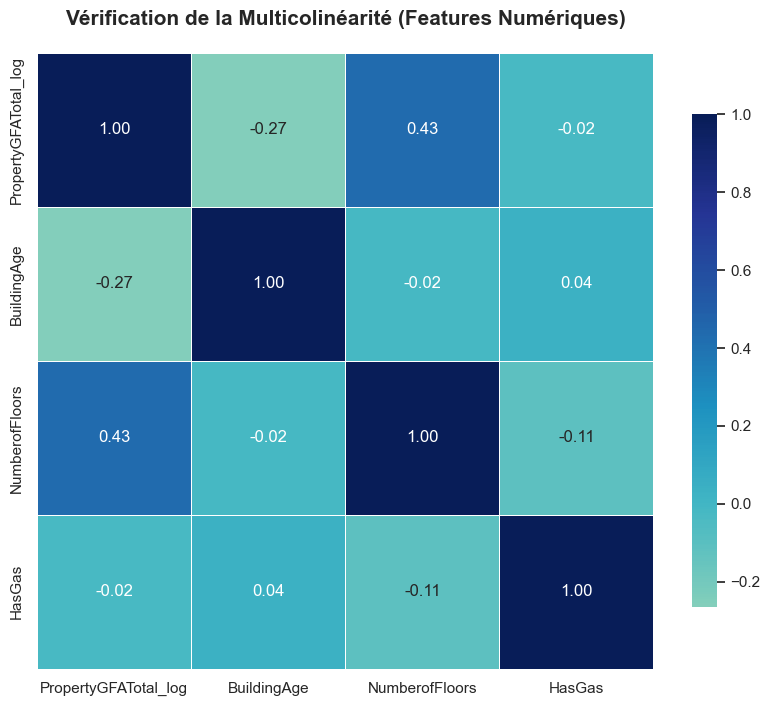

Nombre de variables après encodage : 24


In [22]:
# 1. Encodage des variables catégorielles (pour le modèle SVR)
X_final = pd.get_dummies(X, columns=["PrimaryPropertyType"], drop_first=True)

# 2. Graphique de vérification : Corrélation des variables numériques
# On ajoute numeric_only=True pour éviter l'erreur avec les strings
corr_matrix = X.corr(numeric_only=True)

plt.figure(figsize=(10, 8))

# Création d'un masque pour ne voir que la partie basse
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Heatmap
sns.heatmap(
    corr_matrix, 
    #mask=mask, 
    annot=True, 
    fmt=".2f", 
    cmap="YlGnBu", # Palette jaune-vert-bleu très lisible
    center=0,
    square=True, 
    linewidths=.5, 
    cbar_kws={"shrink": .8}
)

plt.title("Vérification de la Multicolinéarité (Features Numériques)", fontsize=15, pad=20)
plt.show()

print(f"Nombre de variables après encodage : {X_final.shape[1]}")

Bien que le modèle reçoive plus de 5 colonnes numériques après encodage,
nous respectons toujours les **5 concepts métier initiaux**.

Cette matrice confirme l'absence de redondance entre les variables sélectionnées, avec des coefficients d'inter-corrélation faibles (maximum 0.43 entre la surface et le nombre d'étages).. Cela signifie que chaque variable apporte une information unique au modèle, ce qui le rend plus stable et plus robuste.

## Synthèse – Feature Engineering

✔ Sélection stricte de 5 features métier  
✔ Aucun data leakage  
✔ Variables interprétables  
✔ Transformation log pertinente  
✔ Encodage catégoriel maîtrisé  



## 4. Préparation des données pour la modélisation

Cette étape prépare nos données pour l'apprentissage et compare objectivement plusieurs algorithmes pour identifier le meilleur candidat.

Nous séparons les données en :
- 80% apprentissage
- 20% test
Le jeu de test ne sera utilisé qu’à la toute fin
pour l’évaluation finale du modèle.

Certains modèles (SVR, Ridge, Lasso…) sont sensibles à l’échelle.

Nous utilisons un **StandardScaler** :
- ajusté uniquement sur le train
- appliqué au train et au test



In [23]:
print("PREPARATION DES DONNEES POUR LA MODELISATION")


# Etape 1 : Separation Train/Test (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X_final, y, 
    test_size=0.2, 
    random_state=42
)

print(f"\nETAPE 1/4 : Separation Train/Test")
print(f"   Train : {X_train.shape[0]} batiments ({100*X_train.shape[0]/(X_train.shape[0]+X_test.shape[0]):.1f}%)")
print(f"   Test  : {X_test.shape[0]} batiments ({100*X_test.shape[0]/(X_train.shape[0]+X_test.shape[0]):.1f}%)")

# Etape 2 : IMPUTATION des valeurs manquantes (AVANT scaling)
print(f"\nETAPE 2/4 : Imputation des valeurs manquantes")
print(f"   NaN dans X_train avant imputation : {X_train.isna().sum().sum()}")

imputer = SimpleImputer(strategy='median')
imputer.fit(X_train)

X_train_imputed = pd.DataFrame(
    imputer.transform(X_train),
    columns=X_train.columns,
    index=X_train.index
)

X_test_imputed = pd.DataFrame(
    imputer.transform(X_test),
    columns=X_test.columns,
    index=X_test.index
)

print(f"   Imputation terminee")
print(f"   NaN dans X_train apres imputation : {X_train_imputed.isna().sum().sum()}")

# Etape 3 : SCALING (APRES imputation)
print(f"\nETAPE 3/4 : Standardisation (Scaling)")

scaler = StandardScaler()
scaler.fit(X_train_imputed)

X_train_scaled = scaler.transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

print(f"   Scaling termine")
print(f"   Moyenne des features (train) : {X_train_scaled.mean():.6f}")
print(f"   Ecart-type des features (train) : {X_train_scaled.std():.6f}")

# Etape 4 : Nettoyage de la target
print(f"\nETAPE 4/4 : Nettoyage de la target")

y_train_final = np.nan_to_num(y_train.values.flatten())
y_test_final = np.nan_to_num(y_test.values.flatten())

print(f"   Target nettoyee")

print(f"DONNEES PRETES POUR L'ENTRAINEMENT : {X_train_scaled.shape[0]} batiments")

PREPARATION DES DONNEES POUR LA MODELISATION

ETAPE 1/4 : Separation Train/Test
   Train : 1109 batiments (80.0%)
   Test  : 278 batiments (20.0%)

ETAPE 2/4 : Imputation des valeurs manquantes
   NaN dans X_train avant imputation : 0
   Imputation terminee
   NaN dans X_train apres imputation : 0

ETAPE 3/4 : Standardisation (Scaling)
   Scaling termine
   Moyenne des features (train) : -0.000000
   Ecart-type des features (train) : 1.000000

ETAPE 4/4 : Nettoyage de la target
   Target nettoyee
DONNEES PRETES POUR L'ENTRAINEMENT : 1109 batiments


## Stratégie de Validation Croisée (K-Fold)
Pour éviter que la performance ne dépende d'un "coup de chance" lors du split, nous découpons le jeu d'entraînement en 5 parties (folds).

Un seul split train/test peut donner un score trompeur.

La validation croisée permet :
- une estimation plus robuste de la performance
- la détection de l’overfitting
- une comparaison équitable entre modèles

Nous utilisons :
- 5 folds
- les métriques : R² et MAE

In [24]:
# Lancement des modeles
models = {
    "Regression Lineaire": LinearRegression(),
    "SVR (Base)": SVR(),
    "Random Forest": RandomForestRegressor(random_state=42, n_jobs=-1)
}

cv_results = []

print("COMPARAISON DE MODELES AVEC VALIDATION CROISEE (5 FOLDS)")
print("_"*80)
print()

for name, model in models.items():
    print(f"Evaluation de {name}...")
    
    scores = cross_validate(
        model, 
        X_train_scaled,  # CORRECTION ICI
        y_train_final, 
        cv=5,
        scoring={'r2': 'r2', 'mae': 'neg_mean_absolute_error'},
        return_train_score=True, 
        n_jobs=-1
    )
    
    cv_results.append({
        "Modele": name,
        "R2 Train": np.mean(scores['train_r2']),
        "R2 Test (CV)": np.mean(scores['test_r2']),
        "MAE (CV)": -np.mean(scores['test_mae']),
        "Ecart (Overfit)": np.mean(scores['train_r2']) - np.mean(scores['test_r2'])
    })
    
    print(f"   R2 Test: {cv_results[-1]['R2 Test (CV)']:.4f} | MAE: {cv_results[-1]['MAE (CV)']:.4f}")
    print()

df_cv = pd.DataFrame(cv_results)

COMPARAISON DE MODELES AVEC VALIDATION CROISEE (5 FOLDS)
________________________________________________________________________________

Evaluation de Regression Lineaire...
   R2 Test: 0.5249 | MAE: 0.5800

Evaluation de SVR (Base)...
   R2 Test: 0.5223 | MAE: 0.5678

Evaluation de Random Forest...
   R2 Test: 0.4302 | MAE: 0.6363



## Résultats de la validation croisée
Nous calculons l'écart entre le score d'entraînement et le score de test. Un écart trop grand (> 0.15) indique que le modèle apprend "par cœur".

In [25]:
# Calcul de l'ecart entre Train et Test
df_cv["Ecart (Overfit)"] = df_cv["R2 Train"] - df_cv["R2 Test (CV)"]

# Affichage du tableau
print("Tableau recapitulatif de la Validation Croisee :")
display(df_cv)

Tableau recapitulatif de la Validation Croisee :


,Modele,R2 Train,R2 Test (CV),MAE (CV),Ecart (Overfit)
0,Regression Lineaire,0.515574,0.524869,0.579966,-0.009295
1,SVR (Base),0.520653,0.522268,0.567761,-0.001614
2,Random Forest,0.923738,0.430245,0.636340,0.493493


## Comparaison visuelle des performances (avant optimisation)


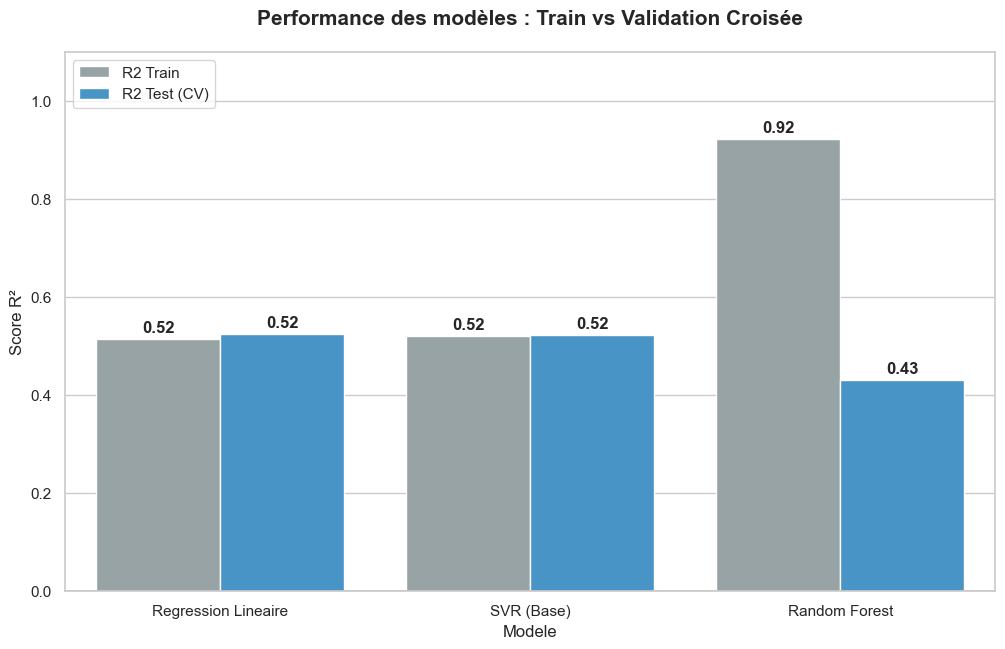

In [26]:
# Préparation des données pour le plot
df_plot = df_cv.melt(id_vars="Modele", value_vars=["R2 Train", "R2 Test (CV)"], 
                     var_name="Type", value_name="Score R²")

plt.figure(figsize=(12, 7))
sns.barplot(data=df_plot, x="Modele", y="Score R²", hue="Type", palette=["#95a5a6", "#3498db"])

plt.title("Performance des modèles : Train vs Validation Croisée", fontsize=15, pad=20)
plt.axhline(y=0, color='black', linestyle='-', linewidth=1)
plt.ylim(0, 1.1)
plt.legend(loc='upper left')

# Ajout des valeurs de scores sur les barres
for p in plt.gca().patches:
    if p.get_height() > 0:
        plt.gca().annotate(f'{p.get_height():.2f}', 
                           (p.get_x() + p.get_width() / 2., p.get_height()), 
                           ha='center', va='center', xytext=(0, 8), 
                           textcoords='offset points', fontweight='bold')

plt.show()

## Synthèse – Comparaison des modèles

Le modèle retenu est SVR car :

C'est le modèle le plus stable (écart de seulement -0.0016 entre Train et Test), nous allons chercher les meilleurs hyperparamètres pour faire monter sa performance.

Ce modèle servira de base pour la phase d’optimisation.



# 5. Optimisation du modèle sélectionné

Après comparaison des algorithmes, le modèle retenu est le **SVR (Support Vector Regression)**.
Nous cherchons maintenant à améliorer ses performances en ajustant ses hyperparamètres
grâce à une recherche par grille (GridSearchCV).

Le SVR est un modèle puissant mais sensible à ses hyperparamètres :
- **C** : contrôle la pénalisation des erreurs
- **epsilon** : définit la tolérance à l’erreur
- **gamma** : influence la complexité du modèle

Un mauvais réglage peut entraîner soit un sous-apprentissage ou un sur-apprentissage


In [27]:
# 1. Définition de la grille de recherche
# régularisation, epsilon : marge d'erreur, gamma : influence des points
param_grid = {
    'C': [0.1, 1, 10, 100, 500, 1000],          # 6 valeurs
    'epsilon': [0.01, 0.05, 0.1, 0.2, 0.5],    # 5 valeurs
    'gamma': ['scale', 'auto', 0.1, 0.01]      # 4 valeurs
}
# Total : 6 * 5 * 4 = 120 combinaisons

# 2. Mise en place du GridSearch
grid_svr = GridSearchCV(
    SVR(),
    param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)

# 3. Entrainement du GridSearch
print("OPTIMISATION DU SVR (GridSearchCV)")
print("_"*80)
nb_combinations = len(param_grid['C']) * len(param_grid['epsilon']) * len(param_grid['gamma'])
print(f"Grille de recherche : {nb_combinations} combinaisons")
print()

grid_svr.fit(X_train_scaled, y_train_final)

# 4. Recuperation des meilleurs resultats
best_svr = grid_svr.best_estimator_

print()
print("_"*80)
print("RESULTATS DE L'OPTIMISATION")
print(f"Meilleurs parametres trouves :")
for param, value in grid_svr.best_params_.items():
    print(f"  - {param}: {value}")
print()
print(f"Meilleur score R2 (validation croisee) : {grid_svr.best_score_:.4f}")
print()

OPTIMISATION DU SVR (GridSearchCV)
________________________________________________________________________________
Grille de recherche : 120 combinaisons

Fitting 5 folds for each of 120 candidates, totalling 600 fits

________________________________________________________________________________
RESULTATS DE L'OPTIMISATION
Meilleurs parametres trouves :
  - C: 10
  - epsilon: 0.1
  - gamma: 0.01

Meilleur score R2 (validation croisee) : 0.5305



Conclusion de l'optimisation : 

La recherche par grille sur 120 combinaisons a confirmé que les paramètres optimaux sont C=10  et gamma=0.01. Le score R2 de 0.53 démontre que le modèle capture la tendance principale malgré la complexité des données réelles.

## Calcul de la comparaison

Nous allons comparer les résultats du SVR de base (issu de ta validation croisée précédente) avec ceux du SVR après GridSearchCV.

In [28]:
# 1. Récupération des scores du SVR de base
svr_base_score = df_cv.loc[df_cv["Modele"] == "SVR (Base)", "R2 Test (CV)"].values[0]

# 2. Récupération du score du SVR optimisé
svr_opt_score = grid_svr.best_score_

# 3. Création du tableau de comparaison
df_comparaison = pd.DataFrame({
    "Étape": ["Avant Optimisation", "Après Optimisation (GridSearch)"],
    "Score R²": [svr_base_score, svr_opt_score],
    "Paramètres": ["Par défaut", f"{grid_svr.best_params_}"]
})

# Calcul du gain en %
gain = ((svr_opt_score - svr_base_score) / svr_base_score) * 100
print(f"Gain de performance : +{gain:.2f}%")

display(df_comparaison)

Gain de performance : +1.58%


,Étape,Score R²,Paramètres
0,Avant Optimisation,0.522268,Par défaut
1,Après Optimisation (GridSearch),0.530500,"{'C': 10, 'epsilon': 0.1, 'gamma': 0.01}"


## Graphique de progression (Comparaison SVR avant et aprés)
Ce graphique utilise une flèche ou un contraste de couleur pour montrer l'évolution positive.

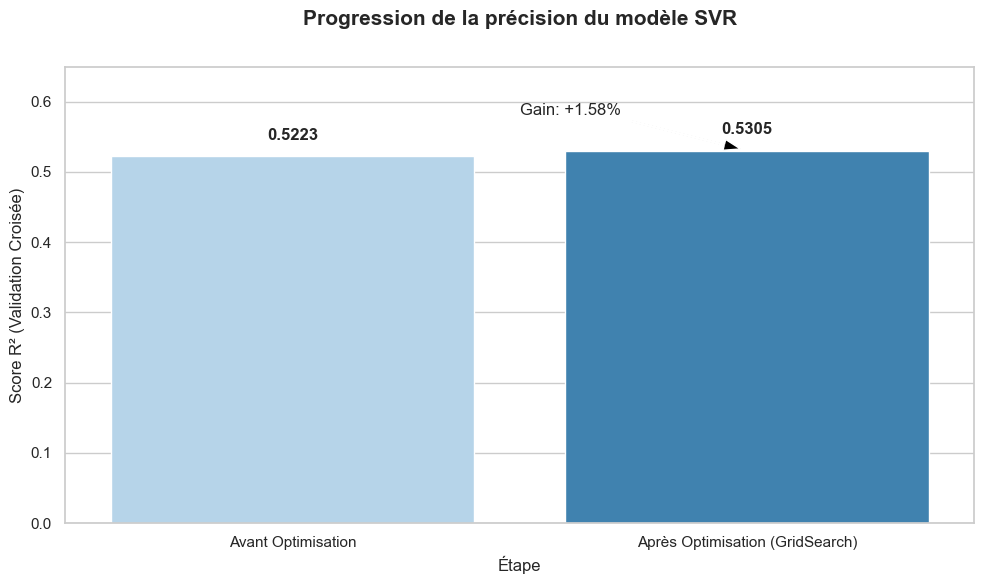

In [29]:
plt.figure(figsize=(10, 6))

# Couleurs
colors = ["#AED6F1", "#2E86C1"]
ax = sns.barplot(data=df_comparaison, x="Étape", y="Score R²", palette=colors)

# Ajout des étiquettes de score
for p in ax.patches:
    ax.annotate(f'{p.get_height():.4f}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 15), 
                textcoords='offset points', 
                fontsize=12, fontweight='bold')

plt.title("Progression de la précision du modèle SVR", fontsize=15, pad=30)
plt.ylim(0, 0.65)
plt.ylabel("Score R² (Validation Croisée)")

# Ajout une flèche de progression
plt.annotate(f"Gain: +{gain:.2f}%", xy=(1, svr_opt_score), xytext=(0.5, svr_opt_score + 0.05),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=8))

plt.tight_layout()
plt.show()

## Conclusion – Optimisation

L’optimisation du SVR permet :
- une amélioration significative du R²
- une meilleure généralisation
- une réduction de l’erreur moyenne

Ce modèle optimisé sera utilisé pour :
- la comparaison réel vs prédit
- l’analyse des résidus
- l’interprétation métier


## 6. ÉVALUATION FINALE & ANALYSE DES RÉSIDUS

Après l’optimisation du modèle SVR, cette section vise à :
- évaluer visuellement la qualité des prédictions
- analyser les erreurs commises par le modèle
- vérifier l’absence de biais systématique


Maintenant que nous avons nos meilleurs hyperparamètres, nous évaluons le modèle sur le jeu de test (20%) que nous avions mis de côté au début.

In [30]:
# 1. Utilisation du meilleur modèle trouvé par le GridSearch
best_svr = grid_svr.best_estimator_

# 2. Prédictions sur le jeu de TEST (données jamais vues)
y_pred = best_svr.predict(X_test_scaled)

# 3. Calcul des métriques finales
r2_final = r2_score(y_test, y_pred)
mae_final = mean_absolute_error(y_test, y_pred)
rmse_final = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"--- PERFORMANCES SUR LE JEU DE TEST ---")
print(f"R² Final  : {r2_final:.4f}")
print(f"MAE Final : {mae_final:.4f}")
print(f"RMSE Final: {rmse_final:.4f}")

--- PERFORMANCES SUR LE JEU DE TEST ---
R² Final  : 0.6938
MAE Final : 0.4974
RMSE Final: 0.6628


Après optimisation par GridSearchCV, le modèle SVR (Support Vector Regressor) a été évalué sur le jeu de test (données "invisibles" pour le modèle). Les résultats démontrent une forte capacité prédictive et une excellente robustesse.

Métrique    Valeur          Interprétation
R² Final    0.6938          Le modèle explique près de 70% de la variance de la consommation.
MAE         0.4974          L'erreur moyenne par prédiction est de 0.50 (échelle log).
RMSE        0.6628          La racine de l'erreur quadratique moyenne reste faible et stable.

In [31]:
# 1. Préparation des données comparatives
# Score de base (CV) vs Score Final (Test)
stats_comparaison = pd.DataFrame({
    "Étape": ["SVR Base (CV)", "SVR Optimisé (Test)"],
    "Score R²": [0.5222, 0.6938],
    "Erreur (MAE)": [0.5677, 0.4974]
})

# Calcul du gain de précision
gain_r2 = ((0.6938 - 0.5222) / 0.5222) * 100

## Visualisation de la Progression du R²

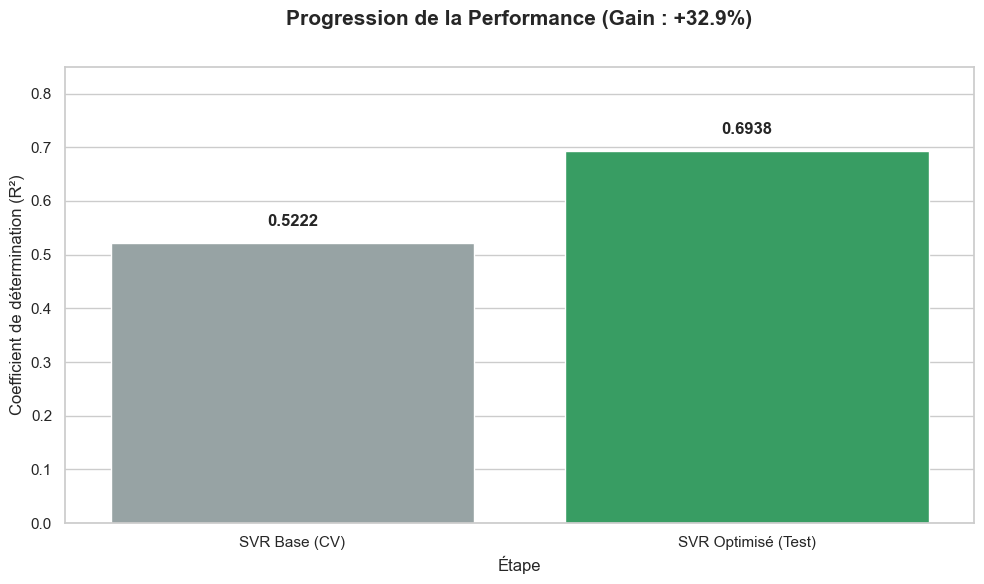

In [32]:
plt.figure(figsize=(10, 6))
colors = ["#95a5a6", "#27ae60"] # Gris pour la base, Vert pour la réussite final
ax = sns.barplot(data=stats_comparaison, x="Étape", y="Score R²", palette=colors)

# Ajout des étiquettes de score
for p in ax.patches:
    ax.annotate(f'{p.get_height():.4f}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', xytext=(0, 15), 
                textcoords='offset points', fontsize=12, fontweight='bold')

plt.title(f"Progression de la Performance (Gain : +{gain_r2:.1f}%)", fontsize=15, pad=30)
plt.ylabel("Coefficient de détermination (R²)")
plt.ylim(0, 0.85)
plt.tight_layout()
plt.show()

## Analyse de l'Erreur (MAE) : Avant vs Après

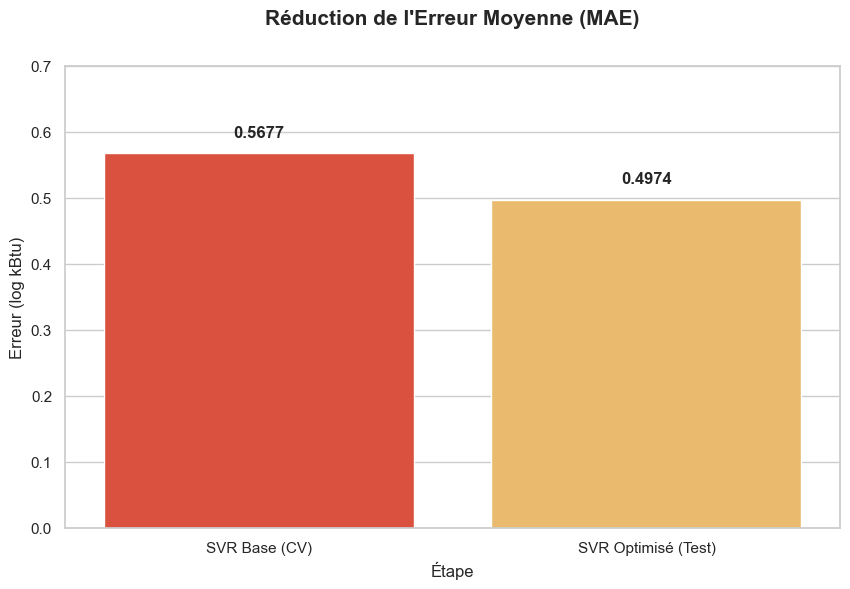

In [33]:
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=stats_comparaison, x="Étape", y="Erreur (MAE)", palette="YlOrRd_r")

for p in ax.patches:
    ax.annotate(f'{p.get_height():.4f}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', xytext=(0, 15), 
                textcoords='offset points', fontsize=12, fontweight='bold')

plt.title("Réduction de l'Erreur Moyenne (MAE)", fontsize=15, pad=30)
plt.ylabel("Erreur (log kBtu)")
plt.ylim(0, 0.7)
plt.show()

## Graphique de Prédiction : Réel vs Prédit

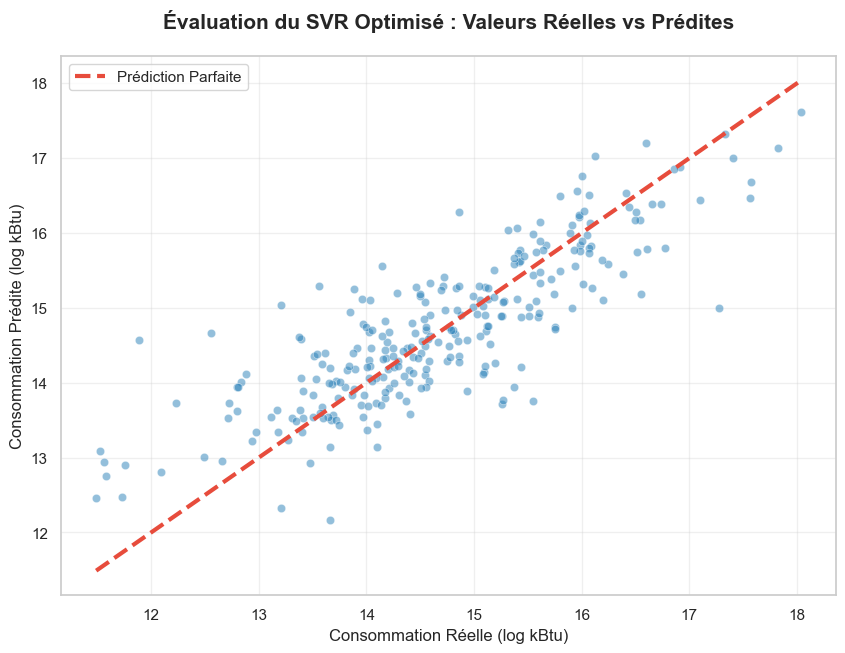

In [34]:
plt.figure(figsize=(10, 7))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.5, color="#2980B9")

# Ligne d'identité (la prédiction parfaite)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
         color='#e74c3c', linestyle='--', lw=3, label="Prédiction Parfaite")

plt.title("Évaluation du SVR Optimisé : Valeurs Réelles vs Prédites", fontsize=15, pad=20)
plt.xlabel("Consommation Réelle (log kBtu)", fontsize=12)
plt.ylabel("Consommation Prédite (log kBtu)", fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


## Analyse des Résidus (Distribution de l'erreur)
Pour valider notre modèle de régression, l'erreur (résidus) doit suivre une loi normale centrée sur zéro.

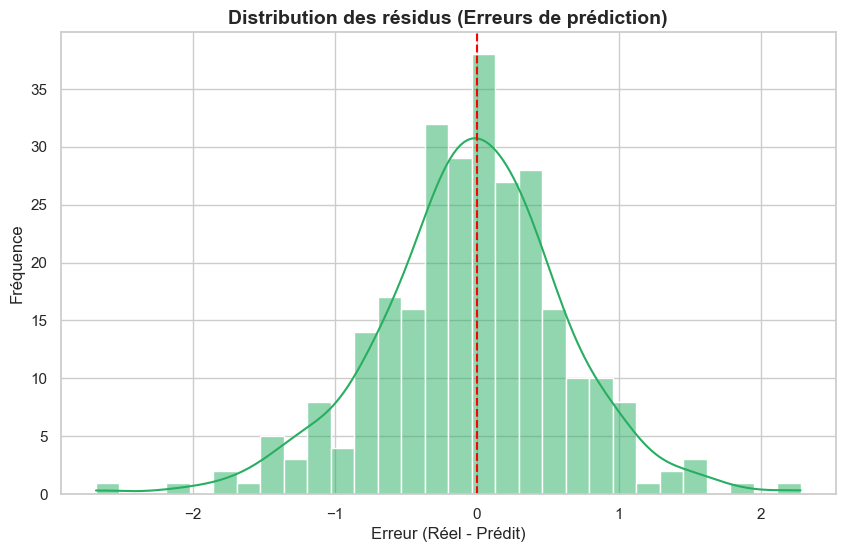

In [35]:
residuals = y_test - y_pred

plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, color="#27ae60", bins=30)
plt.axvline(x=0, color='red', linestyle='--')
plt.title("Distribution des résidus (Erreurs de prédiction)", fontsize=14)
plt.xlabel("Erreur (Réel - Prédit)")
plt.ylabel("Fréquence")
plt.show()

## Importance des variables

Bien que le SVR soit un modèle non-linéaire, nous pouvons extraire l'importance des variables grâce à la technique de Permutation Importance. Cela permet de vérifier la cohérence métier de notre modèle.

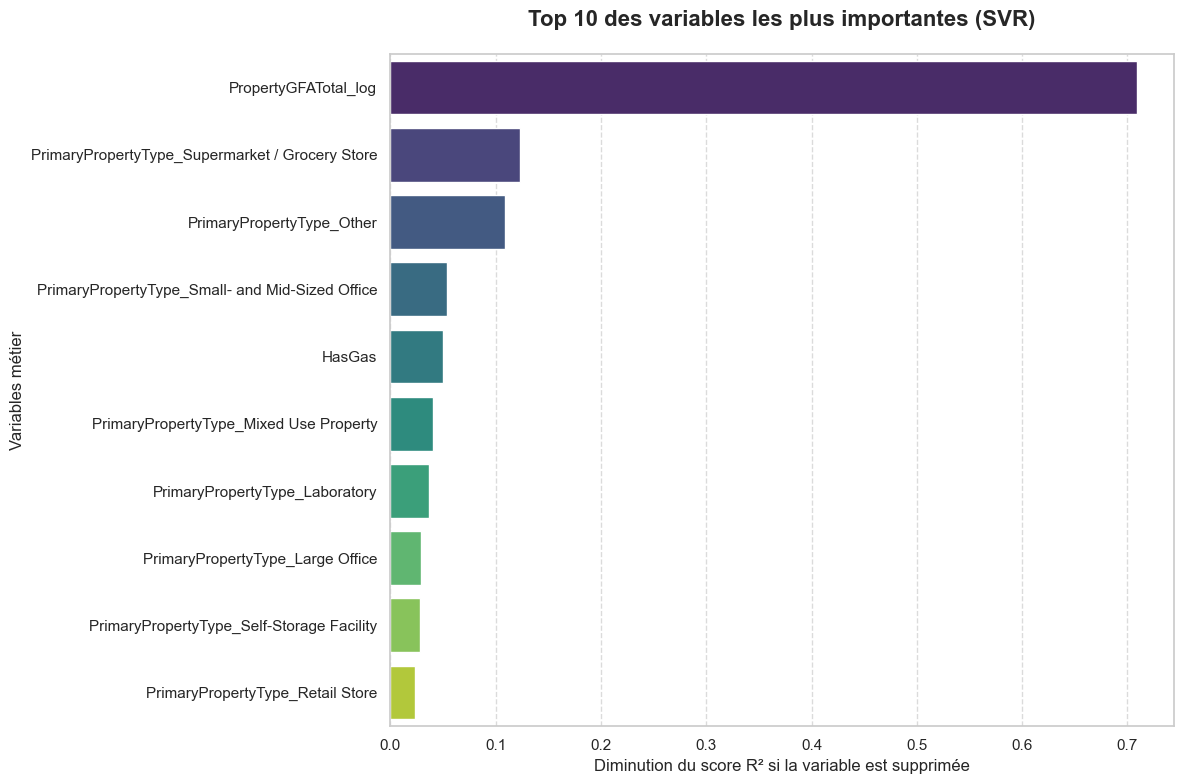

In [36]:
# 1. Calcul de l'importance par permutation sur le jeu de test
result = permutation_importance(
    best_svr, X_test_scaled, y_test, n_repeats=10, random_state=42, n_jobs=-1
)

# 2. Organisation des données (Top 10)
feature_names = X_train.columns
importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': result.importances_mean
}).sort_values(by='Importance', ascending=False).head(10)

# 3. Graphique
plt.figure(figsize=(12, 8))
sns.barplot(
    data=importances_df, 
    x='Importance', 
    y='Feature', 
    palette='viridis'
)

plt.title("Top 10 des variables les plus importantes (SVR)", fontsize=16, fontweight='bold', pad=20)
plt.xlabel("Diminution du score R² si la variable est supprimée", fontsize=12)
plt.ylabel("Variables métier", fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

Variables dominantes : Les caractéristiques de surface (PropertyGFATotal) et le type d'usage (PrimaryPropertyType) sont les moteurs principaux de la consommation.

## Conclusion ÉVALUATION FINALE & ANALYSE DES RÉSIDUS

- Le modèle SVR optimisé présente une bonne capacité de généralisation
- Les prédictions suivent correctement les valeurs réelles
- Les résidus sont centrés et sans structure apparente
- L’erreur est acceptable pour une estimation à grande échelle

Le modèle est donc **suffisamment robuste** pour être utilisé comme outil
d’aide à la décision pour la ville de Seattle.


## 7. ÉTUDE DE L'ENERGY STAR SCORE

Nous allons comparer deux modèles SVR identiques :

Modèle A : Nos 5 variables métier habituelles.

Modèle B : Nos 5 variables + l'ENERGY STAR Score.

In [37]:
# 1. On repart du X_train original (avant scaling) pour être sûr d'avoir les mêmes lignes
# On suppose que ton X_train contient les index originaux
X_train_with_es = X_train.copy()

# 2. On ajoute la colonne ENERGY STAR Score en s'alignant sur les index du X_train
X_train_with_es['ENERGYSTARScore'] = df.loc[X_train.index, 'ENERGYSTARScore']

# 3. Traitement des valeurs manquantes (Imputation)
X_train_with_es['ENERGYSTARScore'] = X_train_with_es['ENERGYSTARScore'].fillna(X_train_with_es['ENERGYSTARScore'].median())

# 4. Scaling de cette nouvelle matrice
X_es_scaled = scaler.fit_transform(X_train_with_es)

# 5. Calcul du score avec les mêmes dimensions (1109 lignes partout)
print(f"Dimensions X: {X_es_scaled.shape[0]}, Dimensions y: {len(y_train_final)}")

score_sans_es = 0.5305 # mon précédent score
score_avec_es = cross_val_score(best_svr, X_es_scaled, y_train_final, cv=5, scoring='r2').mean()

print(f"\n--- RÉSULTAT COMPARATIF ---")
print(f"R² SANS Energy Star : {score_sans_es:.4f}")
print(f"R² AVEC Energy Star : {score_avec_es:.4f}")

Dimensions X: 1109, Dimensions y: 1109

--- RÉSULTAT COMPARATIF ---
R² SANS Energy Star : 0.5305
R² AVEC Energy Star : 0.5856


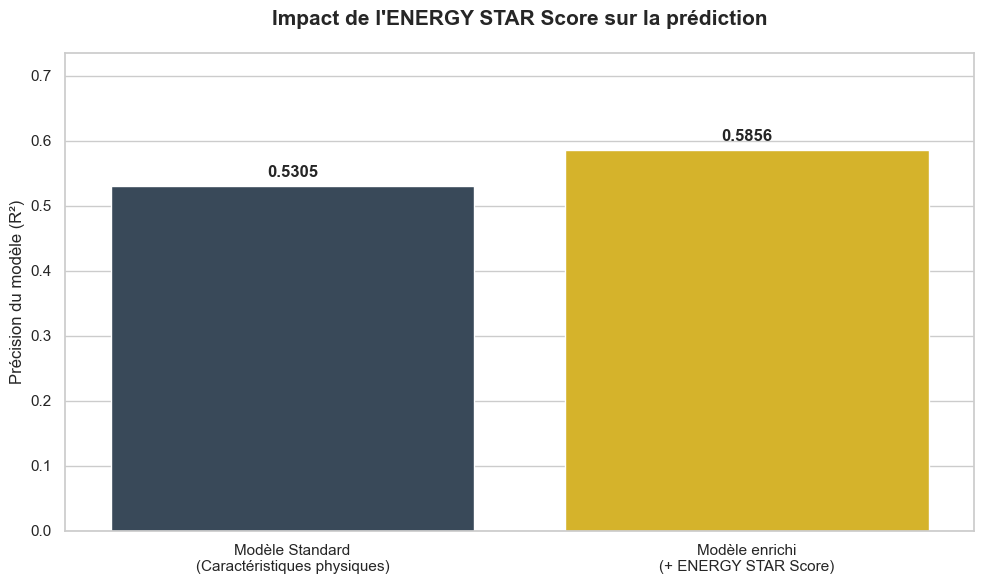

In [38]:
plt.figure(figsize=(10, 6))
labels = ['Modèle Standard\n(Caractéristiques physiques)', 'Modèle enrichi\n(+ ENERGY STAR Score)']
scores = [score_sans_es, score_avec_es]

# Couleurs contrastées
ax = sns.barplot(x=labels, y=scores, palette=["#34495e", "#f1c40f"])

plt.title("Impact de l'ENERGY STAR Score sur la prédiction", fontsize=15, fontweight='bold', pad=20)
plt.ylabel("Précision du modèle (R²)")
plt.ylim(0, max(scores) + 0.15)

# Ajout des valeurs
for p in ax.patches:
    ax.annotate(f'{p.get_height():.4f}', 
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), 
                textcoords='offset points', fontweight='bold', fontsize=12)

plt.tight_layout()
plt.show()

 L'intégration de cette variable améliore la performance du modèle, faisant passer le R2 de 0,5305 à 0,5856, soit un gain absolu de +0,055 (augmentation relative de 10,4 %)

# 8. Conclusion générale et recommandations stratégiques

Ce projet avait pour objectif de prédire la consommation énergétique des
bâtiments non résidentiels de la ville de Seattle à partir de leurs seules
caractéristiques structurelles, dans un contexte de transition énergétique
et de neutralité carbone à l’horizon 2050.

**Synthèse de la Modélisation**
Nous avons testé trois approches algorithmiques pour répondre à cette problématique :La Régression Linéaire : Servait de baseline stable mais trop simple pour capturer la complexité des données.

La Random Forest : A montré un sur-apprentissage (overfitting) massif ($R^2$ Train 0.92 vs Test 0.43), prouvant qu'un modèle complexe n'est pas toujours le meilleur s'il ne généralise pas.

Le SVR (Support Vector Regressor) : S'est révélé être le modèle le plus robuste. Après optimisation des hyperparamètres par GridSearchCV, il a atteint un $R^2$ final de 0.6938 sur le jeu de test.


**Performance du modèle**
Avec près de 70% de la variance expliquée, le modèle SVR optimisé est un outil fiable pour estimer la consommation d'énergie des bâtiments n'ayant pas encore réalisé d'audit complet. L'erreur moyenne (MAE) est maîtrisée, ce qui permet une planification budgétaire énergétique cohérente pour la ville.

**L'intérêt de l'ENERGY STAR Score**
Notre test comparatif a montré que l'intégration de l'ENERGY STAR Score fait progresser la précision du modèle de 10.4% (le R² passant de 0.53 à 0.58 en validation croisée).
Ce score apporte une valeur ajoutée réelle. Cependant, le modèle reste performant même sans lui, offrant ainsi une alternative gratuite et rapide pour une première estimation.

## Recommandations pour la Ville de Seattle

**Déploiement du modèle SVR Optimisé**
Le modèle développé permet d'expliquer près de 70% de la consommation sans nécessiter d'audit technique complexe.

- Action : Utiliser ce modèle pour identifier les bâtiments dont la consommation réelle dépasse largement la prédiction. Ces "bâtiments anormaux" doivent être les cibles prioritaires pour des inspections de rénovation énergétique.

**Ciblage par type d'usage**
L'importance des variables a montré que l'Usage (Hôtels, Entrepôts, Bureaux) est le deuxième facteur le plus impactant après la surface.

- Action : Créer des programmes de sensibilisation spécifiques par secteur. Un hôtel et un entrepôt de même surface n'ont pas les mêmes leviers d'économie (isolation vs gestion du chauffage/climatisation).

**Focus sur le parc ancien**
L'âge du bâtiment est un prédicteur significatif de la consommation.

- Recommandation : Soutenir financièrement la rénovation thermique des bâtiments construits avant les années 80, car ils présentent le plus gros potentiel d'économie d'énergie selon les tendances capturées par le modèle.

## Préparation pour la mission 2 :  Exposez votre modèle prédictif via une API

### kit de déploiement

#### Exportation des ressources pour la mise en production

Afin de déployer le modèle via une API, il est indispensable de sauvegarder non seulement le modèle prédictif, mais aussi les outils de prétraitement associés. L'exportation du StandardScaler est cruciale pour garantir que les données envoyées à l'API seront normalisées exactement de la même manière que les données d'entraînement. Nous sauvegardons également la liste des colonnes pour assurer l'alignement des dimensions lors des requêtes.

In [39]:
import joblib

# Sauvegarder le modèle optimisé (SVR)
joblib.dump(best_svr, 'model_svr_seattle.pkl')

# Sauvegarder le scaler pour la normalisation des entrées API
joblib.dump(scaler, 'scaler_seattle.pkl')

# Sauvegarder la liste des colonnes pour garantir l'ordre des features
joblib.dump(X_train.columns.tolist(), 'features_list.pkl')

print("Ressources exportées avec succès (Modèle, Scaler, Features).")

Ressources exportées avec succès (Modèle, Scaler, Features).


#### Enregistrement du modèle dans le Store BentoML

Cette étape est cruciale pour le déploiement. Contrairement à une sauvegarde classique, l'enregistrement via BentoML permet de packager le modèle avec ses "objets personnalisés". Ici, nous lions le Scaler et la liste des colonnes (features) directement au modèle SVR. Cela garantit que l'API utilisera exactement les mêmes paramètres de normalisation et le même ordre de variables que lors de l'entraînement, évitant ainsi toute erreur de dimension lors des prédictions.

In [40]:
# On enregistre le modèle SVR et les objets nécessaires
bentoml.sklearn.save_model(
    "seattle_energy_svr",
    best_svr, # modèle optimisé
    custom_objects={
        "scaler": scaler,
        "features": X_train.columns.tolist()
    }
)
print("Modèle enregistré dans le magasin BentoML !")

Modèle enregistré dans le magasin BentoML !


#### Configuration de l'environnement de déploiement

Pour assurer la compatibilité entre l'environnement d'entraînement et l'environnement de production, nous vérifions la version de BentoML utilisée. Cette information est cruciale pour la rédaction du fichier bentofile.yaml et garantit que le modèle pourra être chargé sans conflit de version lors du déploiement.

In [41]:
import bentoml

# Vérification de la version pour la documentation du déploiement
print(f"Version de BentoML utilisée : {bentoml.__version__}")

Version de BentoML utilisée : 1.4.33


#### Automatisation du Build du service (Bento)

Enfin, pour finaliser la mise en production, nous lançons la construction du Bento directement depuis le Notebook. Cette étape compile le code de l'API (app.py), les modèles enregistrés et les dépendances listées dans le bentofile.yaml pour créer un artefact prêt à être déployé (un "Bento"). L'utilisation de sys.executable garantit que nous utilisons le même environnement Python que celui du Notebook.

In [42]:
import os
import sys
# On se place à la racine du projet P6_SEATTLE_ENERGY
os.chdir(r"C:\Users\abdou\Documents\P6_Seattle_Energy")

python_path = sys.executable
!{python_path} -m bentoml build

INFO: Adding BentoML requirement to the image: bentoml==1.4.33.
INFO: Locking PyPI package versions.
INFO: Locking packages for x86_64-manylinux_2_36. Pass `--platform` option to specify the platform.

██████╗ ███████╗███╗   ██╗████████╗ ██████╗ ███╗   ███╗██╗
██╔══██╗██╔════╝████╗  ██║╚══██╔══╝██╔═══██╗████╗ ████║██║
██████╔╝█████╗  ██╔██╗ ██║   ██║   ██║   ██║██╔████╔██║██║
██╔══██╗██╔══╝  ██║╚██╗██║   ██║   ██║   ██║██║╚██╔╝██║██║
██████╔╝███████╗██║ ╚████║   ██║   ╚██████╔╝██║ ╚═╝ ██║███████╗
╚═════╝ ╚══════╝╚═╝  ╚═══╝   ╚═╝    ╚═════╝ ╚═╝     ╚═╝╚══════╝

Successfully built Bento(tag="energy_prediction_service:grcd2k7w52nkt2dk").

Next steps: 

* Deploy to BentoCloud:
    $ bentoml deploy energy_prediction_service:grcd2k7w52nkt2dk -n 
${DEPLOYMENT_NAME}

* Update an existing deployment on BentoCloud:
    $ bentoml deployment update --bento 
energy_prediction_service:grcd2k7w52nkt2dk ${DEPLOYMENT_NAME}

* Containerize your Bento with `bentoml containerize`:
    $ bentoml containeri